In [1]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error


In [2]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler())
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(std_scaler, OH_encoder, LinearSVR(
    random_state=42, dual=False, loss='squared_epsilon_insensitive'))
C_range = np.logspace(-2, 0, num=15)
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10,
                  scoring='neg_root_mean_squared_error', param_grid={'linearsvr__C': C_range})
# @NOTE: LinearSVR is faster implementation of SVR and is much faster than rbf to train. Did not explore other kernels due to runtime cost.
# @NOTE: Training time for rbf kernel is very sensitive to the gamma parameter.


In [3]:
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 16, 17, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/p

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper-1',
                                        SklearnTransformerWrapper(transformer=StandardScaler())),
                                       ('sklearntransformerwrapper-2',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'L...
                                                                             'GarageFinish',
                                                                             'PavedDrive', ...])),
                                       ('linearsvr',
                                        LinearSVR(dual=False,
                                                  loss='squared_epsilon_insensitive',
                                                  random_state=42))]),
             n_jobs=3,
             param_grid={'linearsvr__C': array([0.01      , 0.01389495, 0.01930698, 0.02682696, 0.03727594,
       0.05179475, 0.07196857, 0.1       , 0.13894955, 0.19306977,
       0.26826958, 0.37275937, 0.51794747, 0.71968567, 1.        ])},
             scoring='neg_root_mean_squared_error')

In [4]:
gs.best_params_


{'linearsvr__C': 0.019306977288832496}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

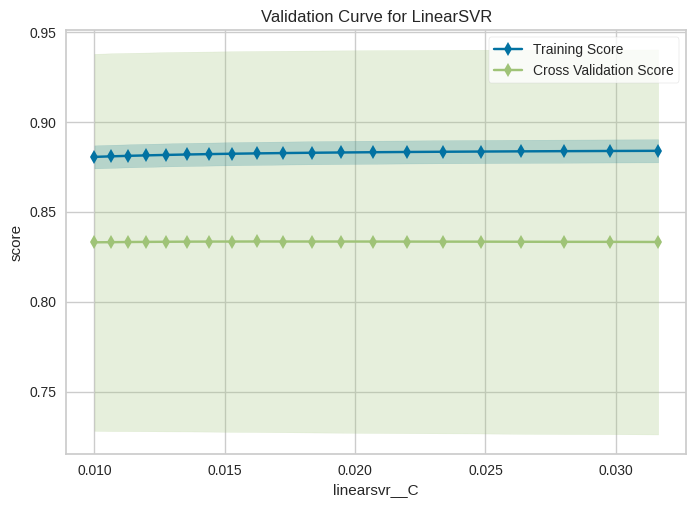

<AxesSubplot: title={'center': 'Validation Curve for LinearSVR'}, xlabel='linearsvr__C', ylabel='score'>

In [5]:
pipe_validation = make_pipeline(std_scaler, OH_encoder, LinearSVR(
    random_state=42, dual=False, loss='squared_epsilon_insensitive'))
new_C_range = np.logspace(-2, -1.5, num=20)
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='linearsvr__C', param_range=new_C_range
)
# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


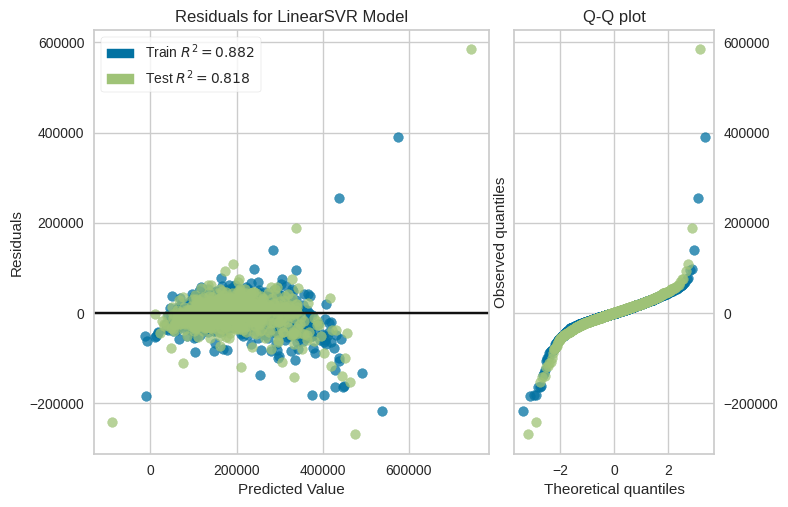

<AxesSubplot: title={'center': 'Residuals for LinearSVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
pipe_final = make_pipeline(std_scaler, OH_encoder, LinearSVR(
    C=0.0193, random_state=42, dual=False, loss='squared_epsilon_insensitive'))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [7]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 34058.34988029099


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 15, 16, 17, 18, 23, 25, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
save_score(gs.best_params_, rmse_test)
